In [1]:
import nltk
# nltk.download('punkt', download_dir='NLTK_DATA')
# nltk.download('stopwords', download_dir='NLTK_DATA')
nltk.data.path.append("NLTK_DATA")
import pandas as pd
import numpy as np
from processing import freqs, normalisasi
from sentiment import *

# PREPARASI *TRAINING DATASET*

In [2]:
# TODO: pindah ke sqlite
dataset = pd.read_csv("dataset/training_dataset.csv")
all_pos = dataset[dataset['label'] == 1]
all_neg = dataset[dataset['label'] == 0]

# * Training data: 80% pertama
# * Testing data: 20% terakhir
train_pos = all_pos[:int(len(all_pos)*0.8)]
train_neg = all_neg[:int(len(all_neg)*0.8)]
test_pos = all_pos[-int(len(all_pos)*0.2):]
test_neg = all_neg[-int(len(all_neg)*0.2):]

train_x = train_pos.append(train_neg, ignore_index=True)
test_x = test_pos.append(test_neg, ignore_index=True)

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

/tmp/ipykernel_23136/3910910574.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_x = train_pos.append(train_neg, ignore_index=True)
/tmp/ipykernel_23136/3910910574.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_x = test_pos.append(test_neg, ignore_index=True)


In [7]:
# ld = len(dataset)
# trp = len(train_pos)
# tng = len(train_neg)
# tsp = len(test_pos)
# tsn = len(test_neg)
# print(f"dataset: {ld} \n train pos: {trp} \n train neg: {tng} \n test pos: {tsp} \n test neg: {tsn}")

# PELATIHAN *MODEL CLASSIFIER*

In [9]:
x = train_x['text']
y = train_y
kamus_frek = kamus_freq(x, y)

In [ ]:
kamus_frek

In [ ]:
for x in kamus_frek.keys():
    print(kamus_frek.get(x, 0))

## logprior
$D$ = jumlah dokumen <br>
$D_{pos}$ = jumlah dokumen positif <br>
$D_{neg}$ = jumlah dokumen negatif <br>
### probabilitas dokumen positif
$P(D_{pos}) = \frac{D_{pos}}{D}$
### probabilitas dokumen negatif
$P(D_{neg}) = \frac{D_{neg}}{D}$
### probabilitas prior
${logprior} = log \left( \frac{P(D_{pos})}{P(D_{neg})} \right) = log \left( \frac{D_{pos}}{D_{neg}} \right)$
<br> disederhanakan, menjadi: <br>
$logprior = P(D_{pos}) - P(D_{neg})$

## loglikelihood
$W$ = probabilitas positif/negatif kata <br>
$freq$ = frekuensi kata unik yang bernilai positif/negatif <br>
$N$ =  jumlah total kata positif/negatif <br>
$V$ = jumlah total kata unik (panjang dokumen frekuensi) <br>
### probabilitas kata positif
$P(W_{pos}) = \frac{freq_{pos} + 1}{N_{pos} + V}$
### probabilitas kata negatif
$P(W_{neg}) = \frac{freq_{neg} + 1}{N_{neg} + V}$
### likelihood kata
$\text{loglikelihood} = \log \left(\frac{P(W_{pos})}{P(W_{neg})} \right)$

In [14]:
logprior, loglikelihood = train_nbc(kamus_frek, train_y)

## HASIL PENGUJIAN MODEL
- data *training*
- data *testing*

In [43]:
test = test_nbc(test_x['text'], test_y, logprior, loglikelihood)
test

0.8455598455598455

## UJI KESELURUHAN *DATASET*

In [44]:
data_test = test_nbc(dataset['text'], dataset['label'], logprior, loglikelihood)
data_test

0.9461538461538461

## *CONFUSION MATRIX*

## metrik-metrik
-   TP = True Positive
-   TN = True Negative
-   FP = False Positive
-   FN = False Negative
- Populasi = TP+TN+FP+FN
<hr>

### akurasi

jumlah prediksi yang benar. tidak dianjurkan sebagai metrik kunci. <br>
$\frac{TP+TN}{Populasi}$

### miss

jumlah prediksi yang salah <br>
$\frac{FP+FN}{Populasi}$

### presisi

persentase positif yang diprediksi secara akurat. jika FP = 0, maka nilai presisi 100%. <br>
$\frac{TP}{TP+FP}$

### sensitifitas

nilai positif sesungguhnya <br>
$\frac{TP}{TP+FN}$

In [17]:
pdc = pd.DataFrame()
pdc = dataset
pdc['label_prediksi'] = pdc['text'].apply(lambda x: predict_nbc(x, logprior, loglikelihood))

In [18]:
# TODO: Do more testing with thresholds values from 0, 0.5, 0.8, 0.9, 1
# * to note;
# treshold = -0.03272669350255697
# * default treshold is 0
def toLabel(x):
   if x > 0:
       return 1
   elif x < 0:
       return 0
   else:
       return "n"
pdc['prediksi'] = pdc['label_prediksi'].apply(lambda x: toLabel(x))

In [19]:
tr = logprior
def toLabel(x):
   if x > tr:
       return 1
   elif x < tr:
       return 0
   else:
       return "n"
pdc['prediksi_tr'] = pdc['label_prediksi'].apply(lambda x: toLabel(x))

In [20]:
conf_matrix = pd.crosstab(pdc['label'], pdc['prediksi'], rownames=['Actual'], colnames=['Predicted'])
conf_matrix

Predicted,0,1
Actual,,
0,647,14
1,84,555


In [1]:
a = (647+555)/1300
m = (14+84)/1300
p = 555/(555+14)
s = 555/(555+84)
print(f"akurasi:{a}, miss:{m}, presisi: {p}, sensi: {s}.\n F1:{2*(p*s)/(p+s)}")

akurasi:0.9246153846153846, miss:0.07538461538461538, presisi: 0.9753954305799648, sensi: 0.8685446009389671.
 F1:0.9188741721854304


In [21]:
conf2 = pd.crosstab(pdc['label'], pdc['prediksi_tr'], rownames=['Actual'], colnames=['Predicted'])
conf2

Predicted,0,1
Actual,,
0,647,14
1,83,556


In [2]:
a2 = (647+556)/1300
m2 = (14+83)/1300
p2 = 556/(556+14)
s2 = 556/(556+83)
print(f"akurasi:{a2}, miss:{m2}, presisi: {p2}, sensi: {s2}.\n F1:{2*(p2*s2)/(p2+s2)}")

akurasi:0.9253846153846154, miss:0.07461538461538461, presisi: 0.9754385964912281, sensi: 0.8701095461658842.
 F1:0.9197684036393714


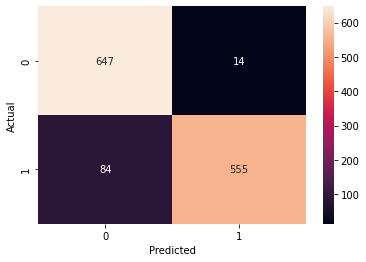

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(conf_matrix, annot=True, fmt='g')
plt.show()

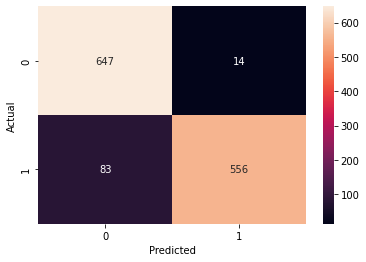

In [23]:
sn.heatmap(conf2, annot=True, fmt='g')
plt.show()

# UJI CLASSIFIER PADA ARTIKEL BERITA

In [24]:
berita = open('berita.txt', 'r')
berita = berita.read()

In [25]:
beritanormal = normalisasi(berita)
frekberita = freqs(beritanormal)
# frekberita

## SENTIMEN ARTIKEL KESELURUHAN

In [26]:
predict_nbc(berita, logprior, loglikelihood)

-33.43289827912097

## SENTIMEN ARTIKEL PER_KALIMAT

In [27]:
from nltk.tokenize import sent_tokenize
x = pd.DataFrame()
kalimat = sent_tokenize(berita)
x['kalimat'] = kalimat
x['kalimat_normal'] = x['kalimat'].apply(lambda x: normalisasi(x))

In [28]:
x['label_prediksi'] = x['kalimat'].apply(lambda x: predict_nbc(x, logprior, loglikelihood))

In [29]:
x

,kalimat,kalimat_normal,label_prediksi
0,"BEIJING, KOMPAS.com - China pada Selasa (10/8/...","[beijing, kompas, china, selasa, tari, utus, l...",-2.345557
1,Taiwan pada Juli mengatakan akan mendirikan ka...,"[taiwan, juli, kantor, wakil, vilnius, kota, l...",-2.631531
2,China menganggap Taiwan bukanlah negara yang b...,"[china, anggap, taiwan, negara, daulat, wilayah]",-2.521048
3,Kementerian Luar Negeri China marah dan pada S...,"[menteri, negeri, china, marah, selasa, perint...",1.176839
4,Keputusan Lithuania mengizinkan Taiwan mendiri...,"[putus, lithuania, izin, taiwan, kantor, wakil...",-2.183537
5,"Selain itu, Kementerian Luar Negeri China meni...","[menteri, negeri, china, nilai, lithuania, ber...",-3.240828
6,China yang mengklaim Taiwan sebagai bagiannya ...,"[china, klaim, taiwan, janji, rebut, keras]",-1.711825
7,China mencoba membuat Taiwan tetap terisolasi ...,"[china, coba, taiwan, isolasi, panggung, dunia...",-1.746012
8,Kementerian Luar Negeri China pada Selasa (10/...,"[menteri, negeri, china, selasa, desak, lithua...",0.664306
9,Kementerian Luar Negeri Lithuania menanggapi d...,"[menteri, negeri, lithuania, tanggap, kecewa, ...",-1.541926


## SENTIMEN ARTIKEL PER_KATA

In [30]:
berita_normal = normalisasi(berita)

In [31]:
# * predict_nbc per-kata
def predict_perkata(text, logpri, loglik):
    l = []
    for w in text:
        x = predict_nbc(w, logpri, loglik)
        l.append({
            w,
            x
            })
    return l

In [32]:
predict_perkata(berita_normal, logprior, loglikelihood)

[{-0.03272669350255697, 'beijing'},
 {-0.03272669350255697, 'kompas'},
 {-0.03272669350255697, 'china'},
 {-0.03272669350255697, 'selasa'},
 {0.658713030751838, 'tari'},
 {-0.03272669350255697, 'utus'},
 {-0.03272669350255697, 'lithuania'},
 {-0.03272669350255697, 'beijing'},
 {-0.03272669350255697, 'vilnius'},
 {-0.03272669350255697, 'izin'},
 {-0.03272669350255697, 'taiwan'},
 {-0.03272669350255697, 'kantor'},
 {-1.8261936190361623, 'negara'},
 {-0.5452597735740978, 'buah'},
 {0.658713030751838, 'langkah'},
 {-0.03272669350255697, 'anggap'},
 {-0.7275813303680526, 'provokatif'},
 {-0.7275813303680526, 'perintah'},
 {-0.03272669350255697, 'china'},
 {-0.03272669350255697, 'taiwan'},
 {-0.03272669350255697, 'juli'},
 {-0.03272669350255697, 'kantor'},
 {-0.7275813303680526, 'wakil'},
 {-0.03272669350255697, 'vilnius'},
 {-0.7275813303680525, 'kota'},
 {-0.03272669350255697, 'lithuania'},
 {-0.5452597735740978, 'buah'},
 {0.658713030751838, 'langkah'},
 {-0.03272669350255697, 'anggap'},
